# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктах за несколько лет. Вам нужно научиться определять рыночную стоимость объектов недвижимости. Для этого проведите исследовательский анализ данных и установите параметры, влияющие на цену объектов. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность.

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта и других объектов — эти данные автоматически получены из геосервисов. Количество парков и водоёмов также заполняется без участия пользователя.

### Откройте файл с данными и изучите общую информацию

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 

In [2]:
df = pd.read_csv('/datasets/real_estate_data.csv', sep='\t')
df.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,...,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


In [3]:
df.info() # выведем общую информацию о таблице, чтобы найти проблемные столбцы

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

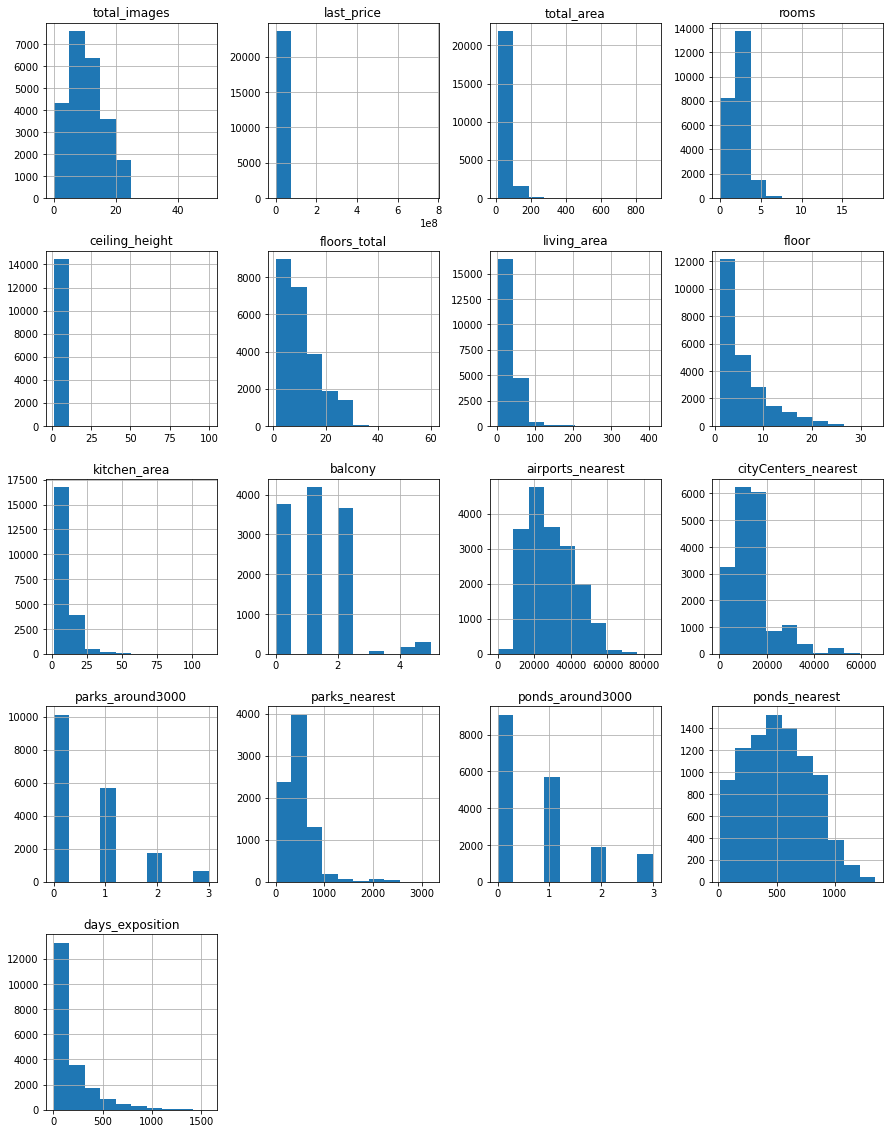

In [4]:
df.hist(figsize=(15, 20)) # строим гистрограмму для всех числовых столбцов таблицы
plt.show()

Вывод:
- были изучены входные данные о продаже квартир, в таблице много пропусков и не верный тип данных для некоторых столбцов, проведем предобработку данных

### Выполните предобработку данных

In [5]:
df.duplicated().sum() # поиск явных дубликатов

0

In [6]:
df.isna().sum() # поиск пропущенных значений

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

In [7]:
pd.DataFrame(round(df.isna().mean()*100,)).style.background_gradient('coolwarm')

,0
total_images,0.000000
last_price,0.000000
total_area,0.000000
first_day_exposition,0.000000
rooms,0.000000
ceiling_height,39.000000
floors_total,0.000000
living_area,8.000000
floor,0.000000
is_apartment,88.000000


In [8]:
# приведем столбец cityCenters_nearest к змеиному регистру
df.rename(columns = {'cityCenters_nearest' : 'city_centers_nearest'})

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.00,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,...,25.00,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.40,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,11.00,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.00,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,...,8.30,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.00,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.00,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,...,41.00,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23694,9,9700000.0,133.81,2017-03-21T00:00:00,3,3.70,5.0,73.3,3,NaN,...,13.83,NaN,Санкт-Петербург,24665.0,4232.0,1.0,796.0,3.0,381.0,NaN
23695,14,3100000.0,59.00,2018-01-15T00:00:00,3,NaN,5.0,38.0,4,NaN,...,8.50,NaN,Тосно,NaN,NaN,NaN,NaN,NaN,NaN,45.0
23696,18,2500000.0,56.70,2018-02-11T00:00:00,2,NaN,3.0,29.7,1,NaN,...,NaN,NaN,село Рождествено,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23697,13,11475000.0,76.75,2017-03-28T00:00:00,2,3.00,17.0,NaN,12,NaN,...,23.30,2.0,Санкт-Петербург,39140.0,10364.0,2.0,173.0,3.0,196.0,602.0


Проанализируем таблицу и поймем в каких стобцах заменить пропуски на 0, а в каких на медианное значение, а в каких на что-то другое.

In [9]:
df = df.dropna(subset=['living_area'])
df = df.dropna(subset=['days_exposition'])
# floors_total - всего этажей в доме, заменим на медианное
df['floors_total'] = df['floors_total'].fillna(df['floors_total'].median())
# is_apartment - апартаменты (булев тип), для начала нужно понять сколько их указали в таблице, чтобы определить ставить False или оставить все как есть.
df['is_apartment'].mean()
# апартаментов почти 2%, думаю пропуски можно заменить на False
df['is_apartment'] = df['is_apartment'].fillna(False)
# kitchen_area -  площадь кухни в квадратных метрах, заменим на медианное
#df['kitchen_area'] = df['kitchen_area'].fillna(df['kitchen_area'].median())
# balcony - наличие балкона, скорее всего можно заменить на 0, не во всех квартирах он есть
df['balcony'] = df['balcony'].fillna(0)
# locality_name - название населенного пункта, тут универсальная замена - unknown
df['locality_name'] = df['locality_name'].fillna('unknown')
# airports_nearest - расстояние до ближайшего аэропорта в метрах, непонятно, аэропорта может и не быть в данном населенном пункте. Оставим без изменений.
# cityCenters_nearest  -расстояние до центра города в метрах, 1. - приведем к змеиному регистру. 2- наверно объект находится очень далеко от центра.
df = df.rename(columns = {'cityCenters_nearest':'city_centers_nearest'})
# parks_around3000 - число парков в радиусе 3 км, скорее всего в данном радиусе нет парков, заменим на 0
df['parks_around3000'] = df['parks_around3000'].fillna(0)
# parks_nearest - расстояние до ближайшего парка, оставим как есть, хотя можно предположить что до парка очень далеко.
# ponds_around3000 - число водоёмов в радиусе 3 км, меняем на 0
df['ponds_around3000'] = df['ponds_around3000'].fillna(0)
# ponds_nearest -  расстояние до ближайшего водоёма в метрах, оставим как есть.
# days_exposition - сколько дней было размещено объявление (от публикации до снятия), непонятно... оставим как есть.


In [10]:
# проверим что получилось
df.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           7457
floors_total                0
living_area                 0
floor                       0
is_apartment                0
studio                      0
open_plan                   0
kitchen_area              722
balcony                     0
locality_name               0
airports_nearest         4117
city_centers_nearest     4097
parks_around3000            0
parks_nearest           12382
ponds_around3000            0
ponds_nearest           11535
days_exposition             0
dtype: int64

Самыми очевидными причинами появления пропусков в данных могут быть:
-человеческий фактор
-заполнение данных разными людьми
-некорректные сохрание и работа с файлом.
-сбои, вирусы в программе.

Теперь пробежимся по типам данных в столбцах

In [11]:
df.head(1)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,False,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0


In [12]:
df['last_price'].astype('int') # в столбце везде целочисленные значение, меняе на целые
df['is_apartment'] = df['is_apartment'].astype(bool) # тут стоит вопрос: это апартаменты?, поэтому булев тип подойдет
df['parks_around3000'] = df['parks_around3000'].astype(int) # по логике, не может быть половина или полтора парка
df['ponds_around3000'] = df['ponds_around3000'].astype(int) # так же как и с парками
df['days_exposition'] = df['days_exposition'].apply(np.floor)
df['days_exposition'] = df['days_exposition'].astype('Int64')
df['floors_total'] = df['floors_total'].astype(int) # думаю объяснять не нужно...
df['balcony'] = df['balcony'].astype(int) # балконов всегде целое количество


In [13]:
df['first_day_exposition'] = pd.to_datetime(df['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S')

Избавимся от неявных дубликатов: возьмем столбец locality_name - название населенного пункта

In [14]:
df['locality_name'].unique()

array(['посёлок Шушары', 'Санкт-Петербург', 'городской посёлок Янино-1',
       'посёлок Парголово', 'посёлок Мурино', 'Ломоносов', 'Сертолово',
       'Петергоф', 'Пушкин', 'деревня Кудрово', 'Колпино', 'Гатчина',
       'поселок Мурино', 'деревня Фёдоровское', 'Выборг', 'Кронштадт',
       'Кировск', 'деревня Новое Девяткино', 'посёлок Металлострой',
       'посёлок городского типа Сиверский', 'поселок Молодцово',
       'поселок городского типа Кузьмоловский', 'Павловск',
       'деревня Пикколово', 'Всеволожск', 'Кингисепп', 'Сестрорецк',
       'деревня Куттузи', 'деревня Заклинье', 'поселок Торковичи',
       'Красное Село', 'посёлок Понтонный', 'Приозерск', 'село Путилово',
       'Ивангород', 'Сланцы', 'Шлиссельбург', 'Сясьстрой', 'Никольское',
       'Зеленогорск', 'Сосновый Бор', 'поселок Новый Свет',
       'деревня Оржицы', 'деревня Кальтино', 'поселок Романовка',
       'посёлок Бугры', 'поселок Бугры', 'поселок городского типа Рощино',
       'Луга', 'Волосово', 'Отрадное

In [15]:
df['locality_name'] = (
    df['locality_name']
    .str.replace('ё','е')
    .replace(['поселок ','городской поселок ', 'пансионат ', 'садоводческое некоммерческое товарищество ',
             'садовое товарищество ', 'станции ', 'село ', 'платформа ', 'городского типа ',
             'деревня ', 'при железнодорожной станции '], '', regex=True)
)

In [16]:
df.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
1,7,3350000.0,40.4,2018-12-04,1,NaN,11,18.6,1,False,...,11.0,2,Шушары,12817.0,18603.0,0,NaN,0,NaN,81
2,10,5196000.0,56.0,2015-08-20,2,NaN,5,34.3,4,False,...,8.3,0,Санкт-Петербург,21741.0,13933.0,1,90.0,2,574.0,558
4,2,10000000.0,100.0,2018-06-19,2,3.03,14,32.0,13,False,...,41.0,0,Санкт-Петербург,31856.0,8098.0,2,112.0,1,48.0,121
5,10,2890000.0,30.4,2018-09-10,1,NaN,12,14.4,5,False,...,9.1,0,городской Янино-1,NaN,NaN,0,NaN,0,NaN,55
6,6,3700000.0,37.3,2017-11-02,1,NaN,26,10.6,6,False,...,14.4,1,Парголово,52996.0,19143.0,0,NaN,0,NaN,155


Вывод:
- Была проделана предобработка данных, улучшили качество записей, убрали пропуски где возможно, в некоторых столбцах, в каких позволено, пропущенные значения были заменены на медианные, изменены типы данных на требуемый для анализа.

### Добавьте в таблицу новые столбцы

Добавим столбцы:

In [17]:
df['price_one_square_meter'] =  (df['last_price'] / df['total_area']).round(2) #- цена одного квадратного метра - price_one_square_meter

In [18]:
df['day_publication'] = df['first_day_exposition'].dt.weekday # день недели публикации объявления (0 — понедельник, 1 — вторник и так далее)

In [19]:
df['month_publication'] = df['first_day_exposition'].dt.month  # месяц публикации объявления

In [20]:
df['year_publication'] = df['first_day_exposition'].dt.year # год публикации объявления

In [21]:
# тип этажа квартиры (значения — «первый», «последний», «другой»);
def floor(row):                      
    if row['floor'] == 1:
        return 'первый'
    if row['floor'] == row['floors_total']:
        return 'последний'
    else:
        return 'другой'

df['type_floor'] = df.apply(floor, axis=1)

In [22]:
df['type_floor'].unique()

array(['первый', 'другой', 'последний'], dtype=object)

In [23]:
# расстояние до центра города в километрах
df['city_center_distance'] = (df['city_centers_nearest'] / 1000).round(0)
df['city_center_distance'].unique()

array([19., 14.,  8., nan, 15., 52., 33., 31., 11., 13., 10.,  2., 12.,
       32.,  4., 16., 17., 30.,  7.,  5., 51., 50., 24.,  9., 28.,  3.,
        6., 27., 49., 35., 36., 34.,  1., 29., 26., 18., 53., 21., 22.,
       55., 20., 23., 25.,  0., 47., 40., 37., 41., 48., 62., 60., 42.,
       65., 39., 54., 66., 43., 59., 61., 63.])

### Проведите исследовательский анализ данных

Проведем исследовательский анализ данных и изучим таблицу по следующим параметрам:

In [24]:
# общая площадь
df['total_area'].describe()

count    18813.000000
mean        58.692194
std         33.628342
min         12.000000
25%         39.400000
50%         50.700000
75%         67.700000
max        900.000000
Name: total_area, dtype: float64

<AxesSubplot:title={'center':'График зависимости общей площади квартир от их количества'}, ylabel='Frequency'>

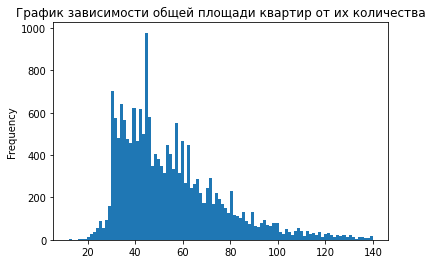

In [25]:
df['total_area'].plot(kind='hist', bins=100, range=(12, 140), title='График зависимости общей площади квартир от их количества')

Вывод;
- больше всего квартир в диапазоне от 35 до 70 квадратых метров
- самая популярная категория - это 45 м2.
- прослеживается тенденция: чем больше больше площадь, тем меньше предложений на рынке.

In [26]:
# жилая площадь
df['living_area'].describe()

count    18813.000000
mean        33.538133
std         21.317216
min          2.000000
25%         18.300000
50%         30.000000
75%         41.600000
max        409.700000
Name: living_area, dtype: float64

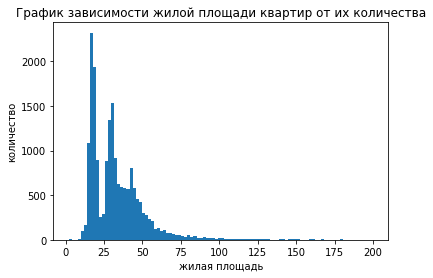

In [27]:
df['living_area'].plot(
    kind='hist',
    bins=100,
    range=(2, 200),
    title='График зависимости жилой площади квартир от их количества')
plt.ylabel('количество')
plt.xlabel('жилая площадь')
plt.show()

Вывод:
- наблюдается 2 пика: набольшее количество квартир с жилой площадью 20 и 30 м2.
- после 50 м2 происходит резский спад.

In [28]:
# площади кухни
df['kitchen_area'].describe()

count    18091.000000
mean        10.390000
std          5.638078
min          2.000000
25%          7.000000
50%          9.000000
75%         11.800000
max        112.000000
Name: kitchen_area, dtype: float64

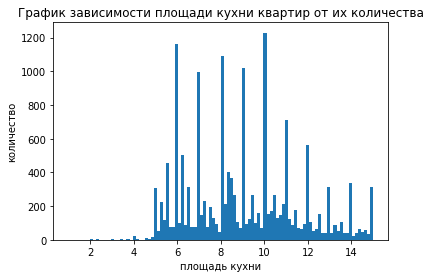

In [29]:
df['kitchen_area'].plot(
    kind='hist',
    bins=100,
    range=(1, 15),
    title='График зависимости площади кухни квартир от их количества')
plt.ylabel('количество')
plt.xlabel('площадь кухни')
plt.show()

Вывод:
- Происходят постояные скачки предложений квартир с площадью кухни 5,7,8,9,10 м2.
- Максимальный показатель 9 м2.
- чем больше кухня тем меньше количество объявлений.

In [30]:
# цена объекта
df['last_price'].describe()

count    1.881300e+04
mean     6.243085e+06
std      1.088887e+07
min      1.219000e+04
25%      3.400000e+06
50%      4.500000e+06
75%      6.500000e+06
max      7.630000e+08
Name: last_price, dtype: float64

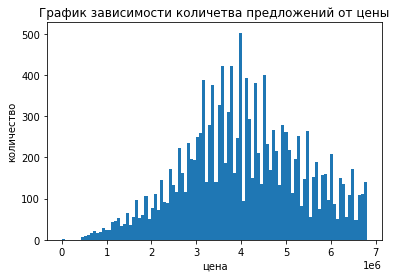

In [31]:
df['last_price'].plot(
    kind='hist', 
    bins=100, 
    range=(1.219000e+04, 6.800000e+06),
    title='График зависимости количетва предложений от цены')
plt.ylabel('количество')
plt.xlabel('цена')
plt.show()

Вывод:
- видим постоянные скачки, следовательно можно сказать что цена не всегда влияет на преложение.
- чаще всего цена квартиры 3.8 млн.

In [32]:
# количество комнат
df['rooms'].describe()

count    18813.000000
mean         2.024026
std          1.057087
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         19.000000
Name: rooms, dtype: float64

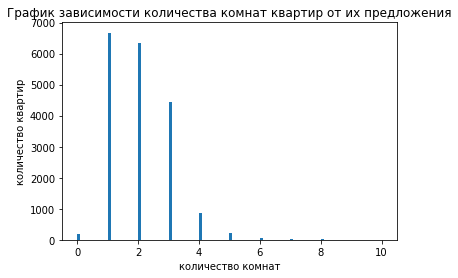

In [33]:
df['rooms'].plot(
    kind='hist',
    bins=100,
    range=(0, 10),
    title='График зависимости количества комнат квартир от их предложения')
plt.ylabel('количество квартир')
plt.xlabel('количество комнат')
plt.show()

Вывод:
- квартир с 1 и 2 комнат больше всего и их предложений почти одинаково
- чем больше комнат, тем меньше объявлений

In [34]:
# высота потолков
df['ceiling_height'].describe()

count    11356.000000
mean         2.763575
std          1.299512
min          1.000000
25%          2.520000
50%          2.650000
75%          2.800000
max        100.000000
Name: ceiling_height, dtype: float64

In [35]:
df['ceiling_height'].unique() # обрабатываем аномальные значения

array([   nan,   3.03,   2.5 ,   2.67,   2.56,   3.05,   2.75,   2.7 ,
         2.6 ,   2.9 ,   2.8 ,   2.55,   3.  ,   3.2 ,   2.65,   3.25,
         3.45,   2.77,   2.85,   2.64,   2.57,   4.15,   3.5 ,   3.3 ,
         2.47,   2.73,   2.84,   3.1 ,   3.4 ,   2.72,   2.54,   2.51,
         2.78,   2.76,  25.  ,   2.58,   3.7 ,   2.52,   5.2 ,   2.87,
         2.66,   2.59,   2.  ,   2.92,   3.11,   3.13,   3.8 ,   3.15,
         3.6 ,   3.55,   3.16,   3.12,   2.53,   2.96,   2.46,   2.74,
         2.45,   4.  ,   2.95,   4.06,   2.79,   3.82,   3.53,   2.83,
         4.7 ,   3.38,   3.65,   3.9 ,   2.71,   3.35,   2.3 ,   3.01,
         2.48,   2.62,   3.57,   2.82,   3.98,   2.63,   3.83,   3.95,
         2.4 ,   2.88,   3.87,   3.66,   3.85,   3.86,   4.19,   3.24,
         4.8 ,   4.2 ,   3.75,   4.5 ,   3.68,   8.  ,   2.94,   3.26,
         3.34,   2.81,   3.07,   3.44,   2.97,   4.37,   2.68,   3.22,
         3.27,   3.52,  27.  ,   2.93,   3.46,  24.  ,   3.47,   3.63,
      

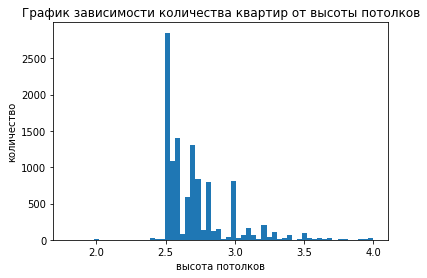

In [36]:
df['ceiling_height'].plot(
    x = df.query('2 < ceiling_height < 4'), 
    kind='hist', 
    bins=60, 
    range=(1.8, 4), 
    title = 'График зависимости количества квартир от высоты потолков')
plt.ylabel('количество')
plt.xlabel('высота потолков')
plt.show()

Вывод:
- Больше всего квартир с высотой потолков 2.6 м.

In [37]:
df.head(1)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_one_square_meter,day_publication,month_publication,year_publication,type_floor,city_center_distance
1,7,3350000.0,40.4,2018-12-04,1,NaN,11,18.6,1,False,...,NaN,0,NaN,81,82920.79,1,12,2018,первый,19.0


<AxesSubplot:title={'center':'График  зависимости цены квартиры от этажа'}, ylabel='last_price'>

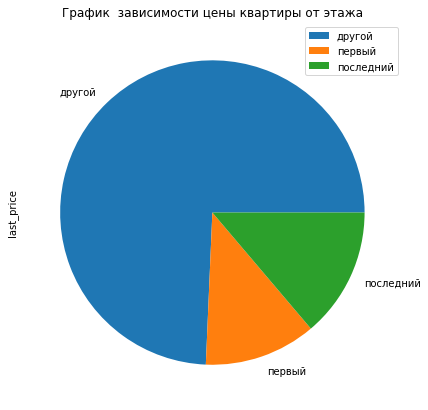

In [38]:
# тип этажа квартиры
df.pivot_table(
    index='type_floor',
    values='last_price',
    aggfunc='count').plot(
    kind='pie',
    y='last_price',
    figsize=(10,7),
    title='График  зависимости цены квартиры от этажа') 

Вывод:
- квартиры между первым и последним этажем стоят дороже, чем квартиры на первом и на последнем этажах.                        

In [39]:
# общее количество этажей в доме
df['floors_total'].describe()

count    18813.000000
mean        10.828629
std          6.614035
min          1.000000
25%          5.000000
50%          9.000000
75%         16.000000
max         60.000000
Name: floors_total, dtype: float64

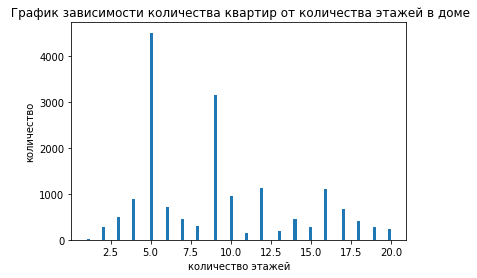

In [40]:
df['floors_total'].plot(
    kind='hist',
    bins=100,
    range=(1, 20),
    title=' График зависимости количества квартир от количества этажей в доме'
)
plt.ylabel('количество')
plt.xlabel('количество этажей')
plt.show()

Вывод:
- Больше всего квартир в домах с 5 этажами.

In [41]:
# расстояние до центра города в метрах
df['city_centers_nearest'].describe()

count    14716.000000
mean     14335.075156
std       8615.529704
min        208.000000
25%       9509.500000
50%      13170.500000
75%      16364.500000
max      65968.000000
Name: city_centers_nearest, dtype: float64

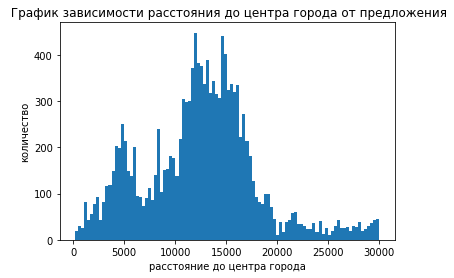

In [42]:
# расстояние до центра города в метрах
df['city_centers_nearest'].plot(
    kind='hist',
    bins=100,
    range=(181, 30000), 
    title=' График зависимости расстояния до центра города от предложения'
)
plt.ylabel('количество')
plt.xlabel('расстояние до центра города')
plt.show()

Вывод:
- наблюдается несколько пиков в 4500, 12000 и 15000 метров. Именно на этих расстояниях до центра больше всего предложений

In [43]:
# расстояние до ближайшего парка
df['parks_nearest'].describe()

count    6431.000000
mean      487.968745
std       339.455669
min         1.000000
25%       286.000000
50%       451.000000
75%       612.000000
max      3190.000000
Name: parks_nearest, dtype: float64

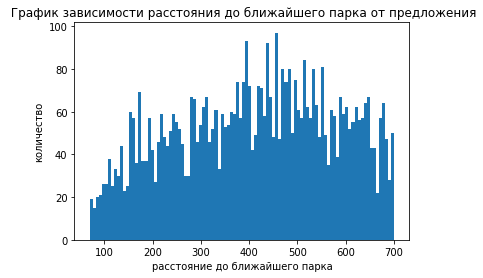

In [44]:
df['parks_nearest'].plot(
    kind='hist',
    bins=100,
    range=(70, 700), 
    title=' График зависимости расстояния до ближайшего парка от предложения'
)  
plt.ylabel('количество')
plt.xlabel('расстояние до ближайшего парка')
plt.show()

Вывод:
- Явной зависимости нет, практически одинаковое количество квартир с расстоянием до ближайшего парка как 150, так и 700 метров.

Итоговый вывод:
На рынке самое разнообразное количество квартир с различными характеристиками.
На основании вышепроведенных исследований можно сделать вывод:
- Самое популярное предложение - это квартира с общей площадью 45 м2, жилой-20 м2, площадью кухни 9 м2, стоимостью 3.8 млн, квартира является однушкой или двухкомнатной, высотой потолков 2.6 м. Квартира также находится не на первом и не на последнем этажах, но в пятиэтажке.
Вероятнее всего находится на окраине города, так как расстояние до центра 13.5 км.

In [45]:
# Изучим, как быстро продавались квартиры
df['days_exposition'].describe()

count    18813.000000
mean       184.898262
std        221.223815
min          1.000000
25%         44.000000
50%        101.000000
75%        239.000000
max       1580.000000
Name: days_exposition, dtype: float64

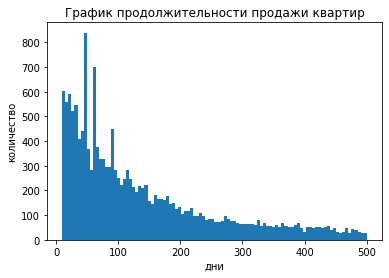

In [46]:
# Изучим, как быстро продавались квартиры
df['days_exposition'].plot(
    kind='hist',
    bins=100,
    range= (10, 500),
    title='График продолжительности продажи квартир')
plt.ylabel('количество')
plt.xlabel('дни')
plt.show()

In [47]:
df['days_exposition'].median()

101.0

Вывод:
- В среднем квартира продается 180 дней, хотя более точный ответ даст медиана 95 дней. В этом случае квартира продается 3 месяца.
Быстрыми продажами можно считать те которые уложились в 45 дней(видно из метода describe)
Долгими, которые преодолели отметку 232 дня.


 Определим факторы, которые больше всего влияют на общую (полную) стоимость объекта.
 Изучим, зависит ли цена от:
- общей площади;
- жилой площади;
- площади кухни;
- количества комнат;
- этажа, на котором расположена квартира (первый, последний, другой);
- даты размещения (день недели, месяц, год).

In [48]:
df.pivot_table(index='floor', values=['last_price','total_area','living_area','kitchen_area','rooms']).corr()

,kitchen_area,last_price,living_area,rooms,total_area
kitchen_area,1.000000,0.428263,0.163425,0.156073,0.490878
last_price,0.428263,1.000000,0.617661,0.429679,0.728986
living_area,0.163425,0.617661,1.000000,0.900903,0.925430
rooms,0.156073,0.429679,0.900903,1.000000,0.815185
total_area,0.490878,0.728986,0.925430,0.815185,1.000000


Вывод:
- есть прямая зависимость между ценой и жилой площадью
- также есть прямая зависмость между ценой и общей площадью
- есть зависимость между ценой и количеством комнат
- слабая зависимость между площадью кухни и ценой

<AxesSubplot:xlabel='total_area', ylabel='last_price'>

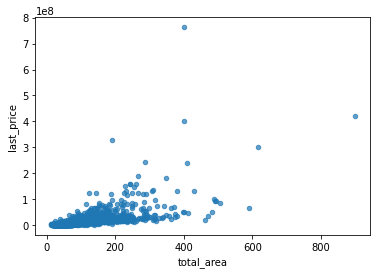

In [49]:

df.plot(x='total_area', y='last_price', kind='scatter', alpha=0.7)

Есть прямая линейная зависимость, наблюдаются аномальные значения хотя их совсем немного.

<AxesSubplot:xlabel='living_area', ylabel='last_price'>

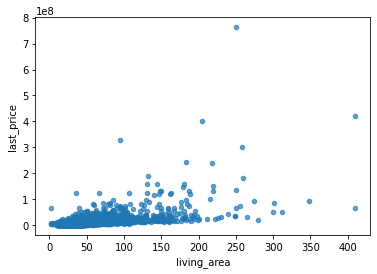

In [50]:
df.plot(x='living_area', y='last_price', kind='scatter', alpha=0.7)

Жилая площадь напрямую влияет на цену квартиры.

<AxesSubplot:xlabel='kitchen_area', ylabel='last_price'>

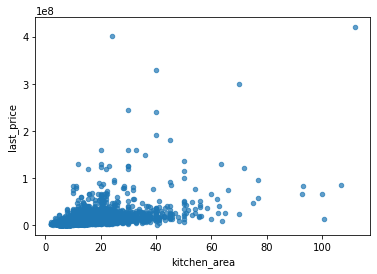

In [51]:
df.plot(x='kitchen_area', y='last_price', kind='scatter', alpha=0.7)

<AxesSubplot:title={'center':'График зависимости цены от количества комнат'}, xlabel='rooms'>

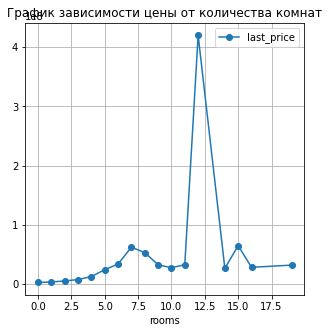

In [52]:
df.pivot_table(index='rooms', values='last_price').plot(style='o-', grid=True, figsize=(5, 5), title='График зависимости цены от количества комнат')

Вывод:
- Квартиры до 12 комнат имеют прямую зависимость со своей ценой, однако в диапазоне 12-15 комнат уже прослеживается обратная зависимость. Скорее всего тут уже надо учеть общую площадь квартиры.

<AxesSubplot:title={'center':'График зависимости цены от типа этажа'}, xlabel='type_floor'>

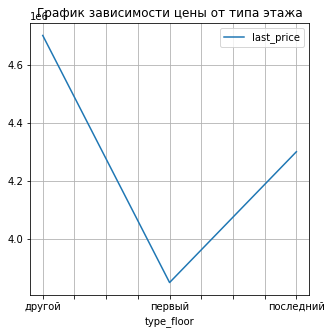

In [53]:
df.pivot_table(index='type_floor', values='last_price', aggfunc='median').plot(
    grid=True, figsize=(5, 5), title='График зависимости цены от типа этажа')

<AxesSubplot:xlabel='day_publication'>

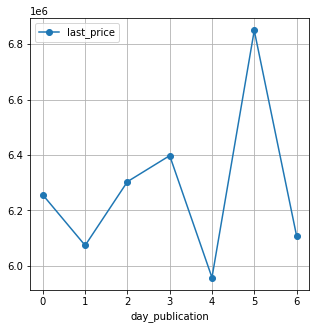

In [54]:
df.pivot_table(index='day_publication', values='last_price').plot(grid=True, style='o-', figsize=(5, 5))    

<AxesSubplot:xlabel='month_publication'>

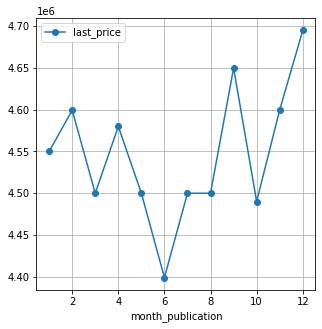

In [55]:
df.pivot_table(index='month_publication', values='last_price', aggfunc='median').plot(grid=True, style='o-', figsize=(5, 5))    

<AxesSubplot:xlabel='year_publication'>

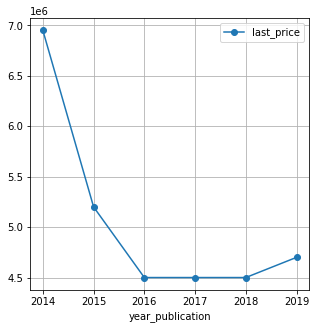

In [56]:
df.pivot_table(index='year_publication', values='last_price', aggfunc='median').plot(grid=True, style='o-', figsize=(5, 5))
    

Вывод:
- Чем больше общая площадь, тем выше стоимость. Корреляция этих параметров крайне высокая.
- Число комнат влияет на цену , однако зависимость ниже, чем у площади, так как бывают квартиры с большими по площади комнатами и квартиры в центре состоят из малого числа комнат, но стоят достаточно высоко.
- В среднем квартиры на 1-м этаже значительно дешевле. Чуть дороже последний этаж.
- Наибольшая стоимость у квартир, расположенных не на 1-м и не на последнем этаже.

Посчитаем среднюю цену одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений.

In [57]:
df['price_per_meter'] = df['last_price']/df['total_area']
loc_name_10 = df.pivot_table(index='locality_name', values='price_per_meter', aggfunc='count')
loc_name_10.columns=['number_of_ads']
loc_name_10['price_per_meter'] = df.pivot_table(index='locality_name', values='price_per_meter').round(2)
loc_name_10.sort_values(by='number_of_ads', ascending=False).head(10).sort_values(by='price_per_meter', ascending=False)

,number_of_ads,price_per_meter
locality_name,,
Санкт-Петербург,12629,111876.62
Пушкин,286,102530.04
Кудрово,394,94755.41
Парголово,277,89816.02
Мурино,487,86384.30
Петергоф,173,83110.83
Шушары,376,78410.95
Колпино,298,74758.01
Всеволожск,314,68842.29


Вывод:
- Из таблицы видно, что самая высокая цена за м2 в Санкт-Петербурге, хотя в его области, точнее в городе Выборг, цена уже в 2 с лишним раза меньше.

In [58]:
df.groupby('locality_name').agg({'balcony':'count', 'last_price':'median'}) \
    .sort_values(by = 'balcony', ascending = False) \
    .head(10)

,balcony,last_price
locality_name,,
Санкт-Петербург,12629,5300000.0
Мурино,487,3400000.0
Кудрово,394,3785000.0
Шушары,376,3900000.0
Всеволожск,314,3350000.0
Колпино,298,3560000.0
Пушкин,286,5100000.0
Парголово,277,4000000.0
Гатчина,253,3030000.0


<div class="alert alert-info"> <b>Комментарии студента:</b> Отправляю в список гениальных решений)
</div>

Узнаем среднюю стоимость квартир в Санкт-Петербурге на разном удалении от центра.

<AxesSubplot:title={'center':'График зависимоти цены от рассояния до центра Санкт-Петербурга'}, xlabel='city_center_distance'>

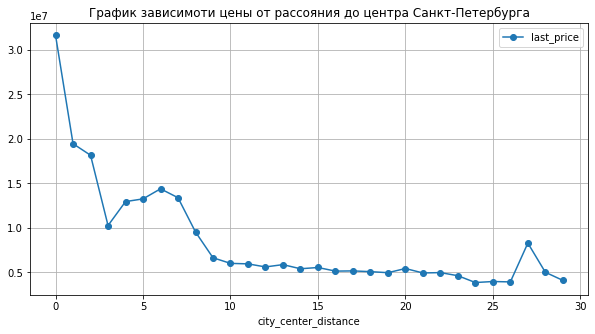

In [59]:
df.query('locality_name == "Санкт-Петербург"').pivot_table(
index='city_center_distance', values='last_price').plot(figsize=(10,5), style='o-', grid=True, title='График зависимоти цены от рассояния до центра Санкт-Петербурга')

Как это не странно,можно заметить, что чем дальше от центра тем дешевле стоимость за м2.

### Напишите общий вывод

В ходе проведенной работы, были сделаны исседования по данным о продаже квартир.
По параметрам:
- общая площадь;
- жилая площадь;
- площадь кухни;
- цена объекта;
- количество комнат;
- высота потолков;
- тип этажа квартиры («первый», «последний», «другой»);
- общее количество этажей в доме;
- расстояние до центра города в метрах;
- расстояние до ближайшего парка;

Был сделан вывод: cреднестатистическое предложение аренды - это квартира с общей площадью 45 м2, жилой-20 м2, площадью кухни 9 м2, стоимостью 3.8 млн, квартира является однушкой или двухкомнатной, высотой потолков 2.6 м. Квартира также находится не на первом и не на последнем этажах, но в пятиэтажке. Вероятнее всего находится на окраине города, так как расстояние до центра 13.5 км
Также было изучено время за которое продавались квартиры:
- В среднем квартира продается 180 дней, хотя более точный ответ даст медиана 95 дней. В этом случае квартира продается 3 месяца.
- Быстрыми продажами можно считать те которые уложились в 45 дней, долгими, которые преодолели отметку 232 дня.
Исседование выявило факторы, которые больше всего влияют на стоимость объекта:
- Чем больше общая площадь, тем выше стоимость.
- Число комнат, но не всегда, нужно учитывать площадь этих комнат, но на цену в квартирах до 12 комнат их количество влияет напрямую.
- первый и последний этаж пользуется меньшим спросом у покупателей следовательно влияет на цену.
Посчитана средняя цена одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений:
- в Санкт-Петербурге самая высокая стоимость за м2
- в Ленинградской области стоимость снижается линейно в зависимости от удаленности от города на Неве.
